## Deep MMD - GAN with MNIST dataset


In [1]:
%matplotlib inline

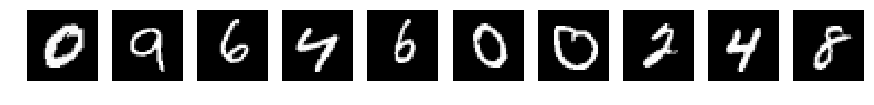

In [3]:
from matplotlib import pyplot as plt

import torch
from torch import nn, optim
from torch.autograd import Variable
from torchvision import datasets, transforms

from utils import GeneratorNet, DiscriminatorNet, show_images


class options:
    cuda = True
    batch_size = 256
    image_size = 32
    n_filters = 100

transform = transforms.Compose([
    transforms.Pad(2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('./datasets/MNIST/',
                   transform=transform, download=True),
    batch_size=256, shuffle=True,
)

for _batch, _ in dataloader:
    show_images(_batch)
    break

0 0 235 15.968667030334473


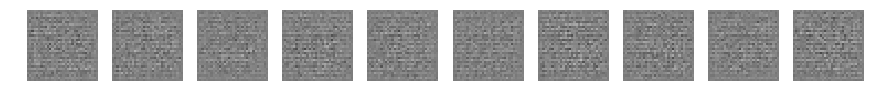

1 0 235 30.797571182250977


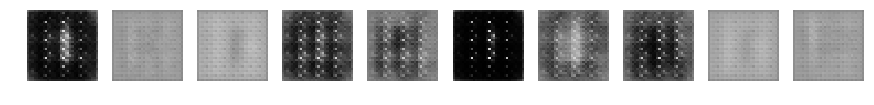

2 0 235 31.91814422607422


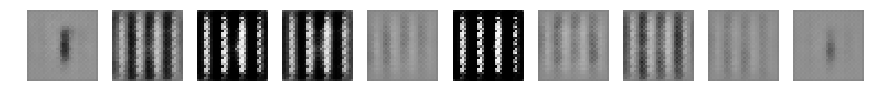

3 0 235 31.108924865722656


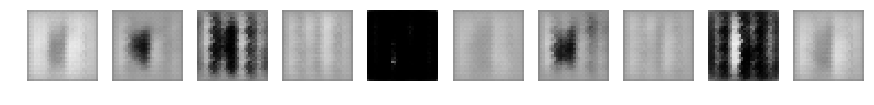

4 0 235 28.66427993774414


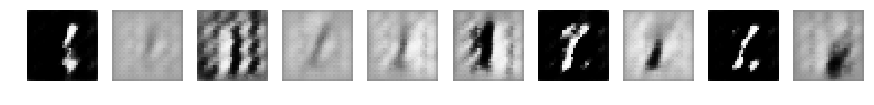

5 0 235 25.019817352294922


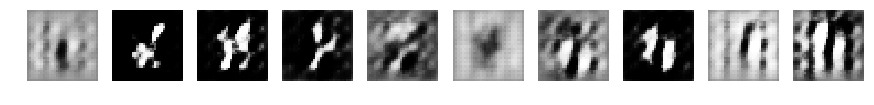

6 0 235 18.412158966064453


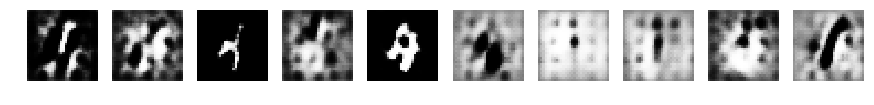

7 0 235 23.256683349609375


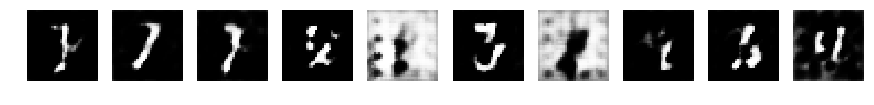

8 0 235 24.408140182495117


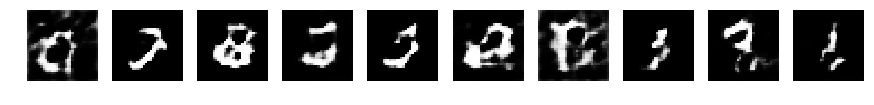

9 0 235 25.769119262695312


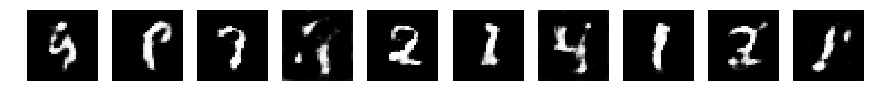

10 0 235 24.406211853027344


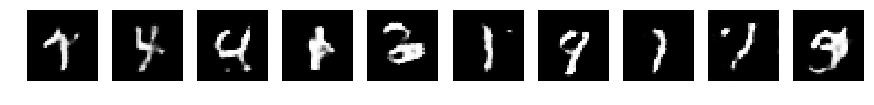

11 0 235 24.2329158782959


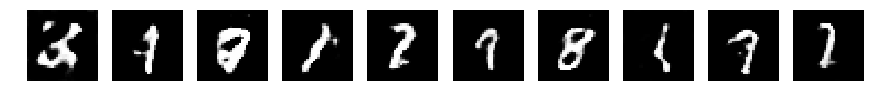

12 0 235 24.231849670410156


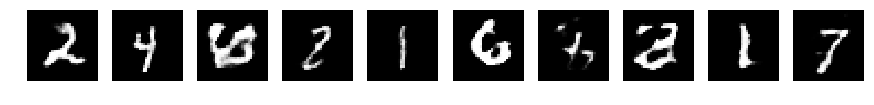

13 0 235 22.151325225830078


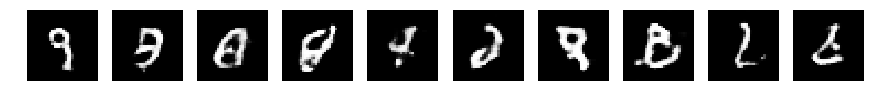

14 0 235 22.7553768157959


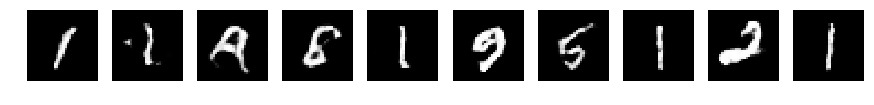

15 0 235 23.058277130126953


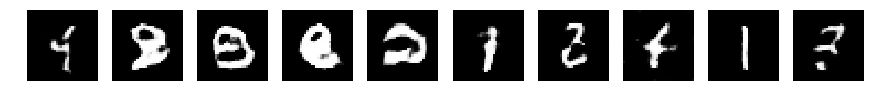

16 0 235 23.435510635375977


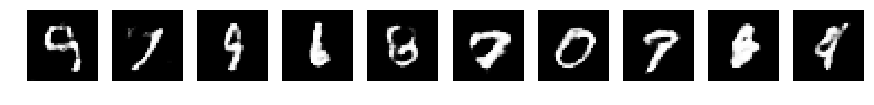

17 0 235 22.984569549560547


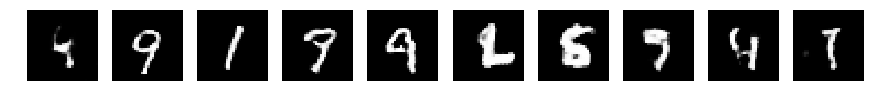

18 0 235 22.646753311157227


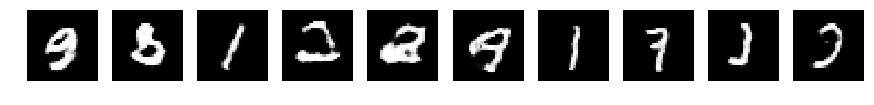

19 0 235 22.41666603088379


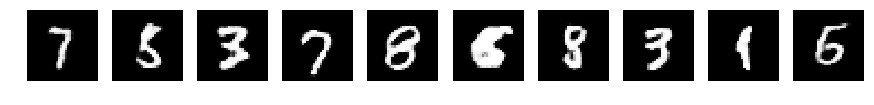

20 0 235 19.9090576171875


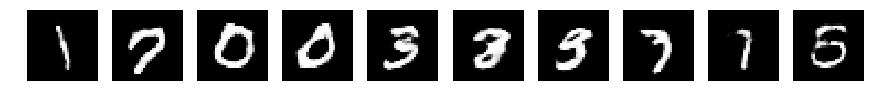

21 0 235 22.105974197387695


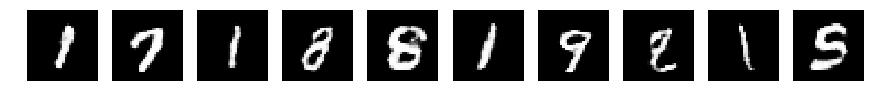

22 0 235 20.69964027404785


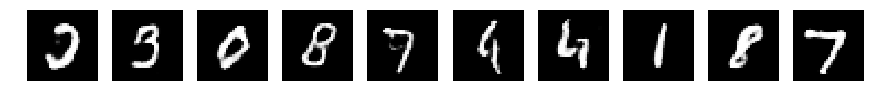

23 0 235 23.085607528686523


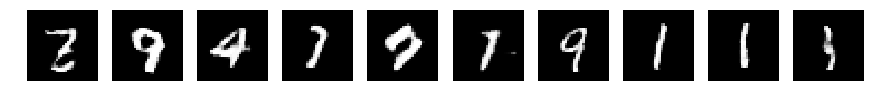

24 0 235 21.96406364440918


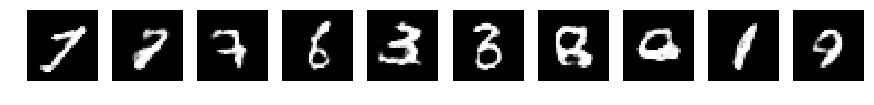

25 0 235 19.961759567260742


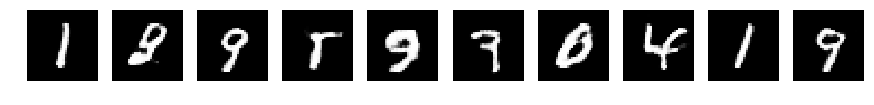

26 0 235 23.201255798339844


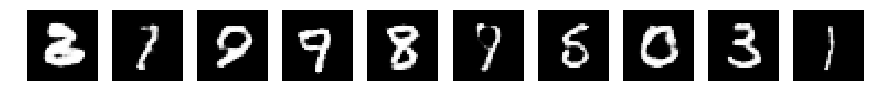

27 0 235 22.782590866088867


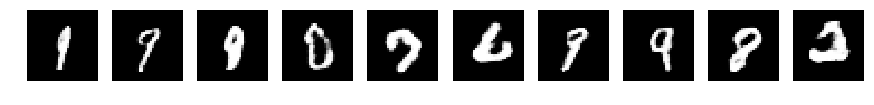

28 0 235 22.0908145904541


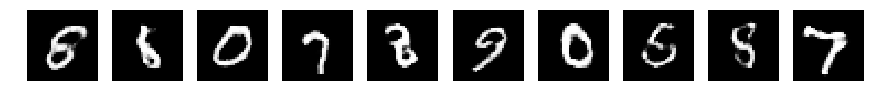

29 0 235 23.0141658782959


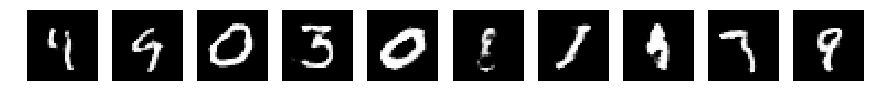

30 0 235 22.275814056396484


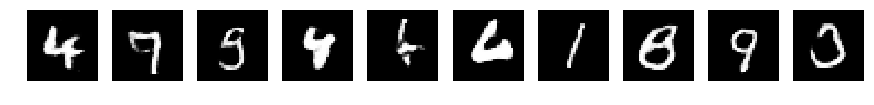

31 0 235 22.33708381652832


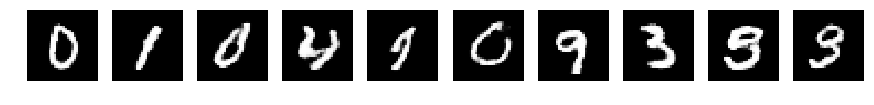

32 0 235 21.91084098815918


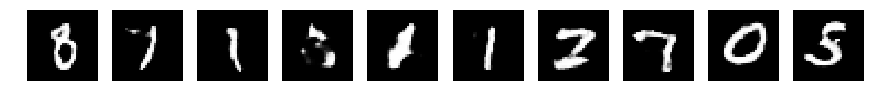

33 0 235 22.99764060974121


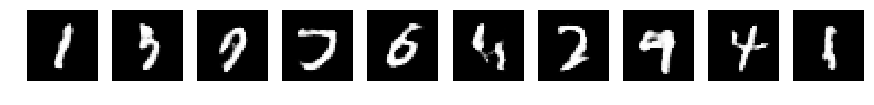

34 0 235 23.886137008666992


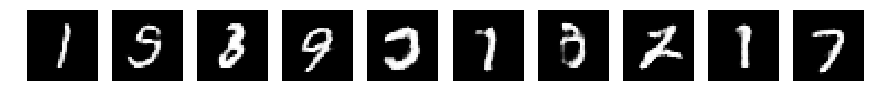

35 0 235 22.679630279541016


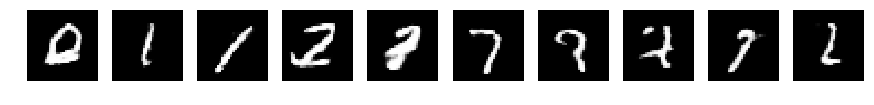

36 0 235 20.38262367248535


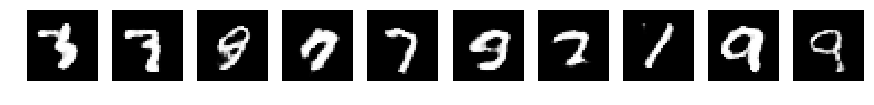

37 0 235 23.216903686523438


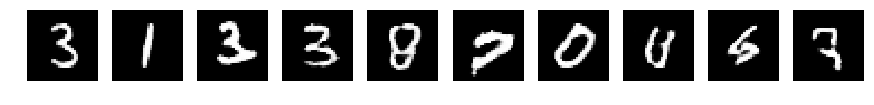

38 0 235 24.01028823852539


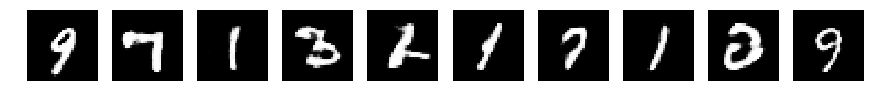

39 0 235 22.403942108154297


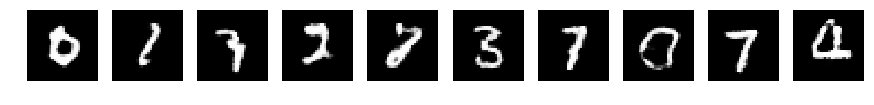

40 0 235 22.204355239868164


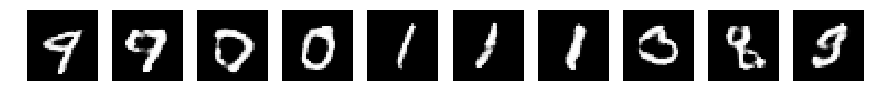

41 0 235 22.223087310791016


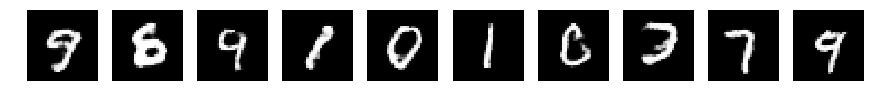

42 0 235 23.75588035583496


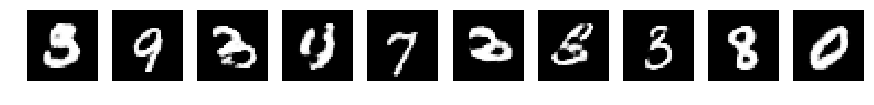

43 0 235 23.275005340576172


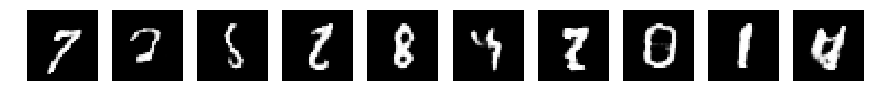

44 0 235 22.48037338256836


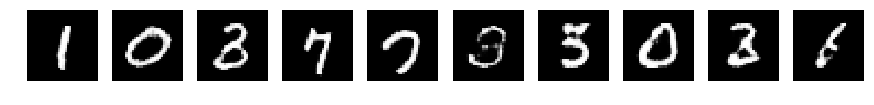

45 0 235 22.692813873291016


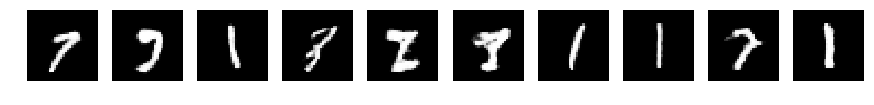

46 0 235 24.177934646606445


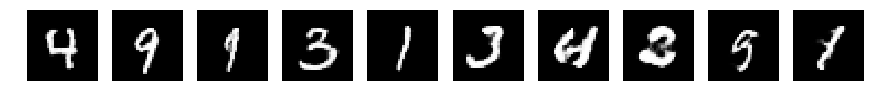

47 0 235 23.377151489257812


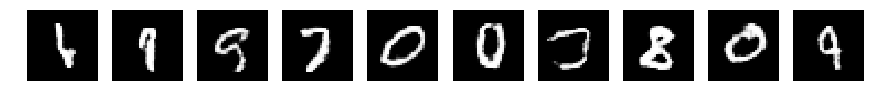

48 0 235 23.792705535888672


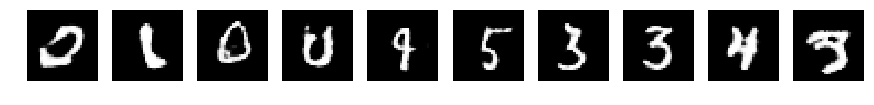

49 0 235 22.170347213745117


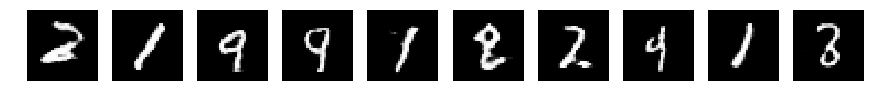

In [4]:
netG = GeneratorNet(input_nfilters=options.n_filters, generator_nfilters=64, image_size=32, n_colors=1)
netD = DiscriminatorNet(discriminator_nfilters=32, image_size=32, n_colors=1)

criterion = nn.BCELoss()

noise = torch.FloatTensor(options.batch_size, options.n_filters, 1, 1)

if options.cuda:
    netD.cuda()
    netG.cuda()
    criterion.cuda()
    noise = noise.cuda()

# setup optimizer.
# Yup, just added minus to learning rate - and that's where you get adeversarial training :)
optimizerD = optim.Adam(netD.parameters(), lr=-1e-4, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=+1e-4, betas=(0.5, 0.999))

for epoch in range(50):
    for i, (real_cpu, _) in enumerate(dataloader):
        netD.zero_grad()
        netG.zero_grad()

        # get real batch
        if options.cuda:
            real_cpu = real_cpu.cuda()
        real = Variable(real_cpu)

        # generate fake
        noise.normal_(0, 1)
        fake = netG(Variable(noise))

        # joint to have common batch-norm transform
        outputs = netD(torch.cat([real, fake], dim=0))
        output_real = outputs[:real.size(0)]
        output_fake = outputs[real.size(0):]

        MMD = torch.norm(output_fake.mean(dim=0) - output_real.mean(dim=0))
        MMD.backward()

        optimizerD.step()
        optimizerG.step()

        if i == 0:
            print(epoch, i, len(dataloader), MMD.data[0])
            show_images(fake.data)